This notebook is supposed to run simulations and generate a time plot for each simulation.

We can define outpath, SEED, MONTE_CARLO_RUNS, TIMESTEPS, simulation_type. Then for each simulation a dir in outpath is created where simulated data is stored. Finally, in each dir a corrsponding plot is generated.

# Imports

In [1]:
from collections import defaultdict
from pathlib import Path
from datetime import datetime
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
from hashlib import sha256

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

# Simulation help functions

In [2]:
from model.types.proposals import Proposal
from model.types.proposal_type import ProposalGeneration, ProposalSubType, ProposalType
from model.types.reaction_time import ModeledReactions
from model.types.scenario import Scenario
from model.utils.initialization import generate_initial_state
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params
from model.utils.postprocessing import postprocessing

from specs.utils import ether_base

def get_simulation_hash(initial_state=None, state_update_blocks=None, params=None, timesteps=None):
    initial_state_str = str(initial_state)
    state_update_blocks_str = str(state_update_blocks)
    params_str = str(params)

    combined_str = initial_state_str + state_update_blocks_str + params_str
    simulation_hash = sha256(combined_str.encode()).hexdigest()

    return simulation_hash + "-" + str(timesteps)


def create_actors_df(simulation_result, out_dir=None):
    if out_dir == None:
        out_dir = Path("")
    out_filepath = out_dir.joinpath(Path("actors.csv"))

    value_dict = defaultdict(list)
    value_dict["reaction_delay"] = []

    index: int = simulation_result["timestep"].head(1).index.tolist()[0]

    for actors in simulation_result["actors"]:
        for actor in actors:
            for key, value in vars(actor).items():
                if re.search("eth", key, flags=re.IGNORECASE):
                    value /= ether_base

                value_dict[key].append(value)
            for key in value_dict:
                if (key not in vars(actor)) and (key not in ("seed", "timestep")):
                    value_dict[key].append(None)

            value_dict["seed"].append(simulation_result["seed"][index])
            value_dict["timestep"].append(simulation_result["timestep"][index])

        index += 1
    df = pd.DataFrame(value_dict)
    return df
    # df.to_csv(out_filepath, index=False)


def save_execution_result(experiment, out_dir=None):
    if out_dir is None:
        out_dir = Path("")

    experiment_df = pd.DataFrame(experiment.results)
    simulations = experiment.get_simulations()

    for run in range(len(simulations)):
        start_idx = run + (run * TIMESTEPS)
        end_idx = start_idx + TIMESTEPS + 1

        simulation_hash = get_simulation_hash(
            initial_state=experiment.simulations[run].model.initial_state,
            state_update_blocks=experiment.simulations[run].model.state_update_blocks,
            params=experiment.simulations[run].model.params,
            timesteps=experiment.simulations[run].timesteps,
        )

        folder_path = out_dir.joinpath(f"{simulation_hash}/")
        folder_path.mkdir(exist_ok=True)

        sliced_df = experiment_df.iloc[start_idx:end_idx]
        result_path = folder_path.joinpath("result.pkl")

        with open(result_path, "wb") as f:
            pickle.dump(sliced_df, f)

        create_actors_df(sliced_df, folder_path)


def setup_simulation(
    timesteps: int,
    monte_carlo_runs: int,
    proposals: list[Proposal],
    attackers: set[str],
    defenders: set[str],
    seed: int,
    simulation_starting_time: datetime,
    outpath=None
):
    if outpath is None:
        outpath = Path("")
    
    simulations: list[Simulation] = []
    simulation_hashes: list[str] = []

    for run in range(monte_carlo_runs):
        seed_str = seed + run
        state = generate_initial_state(
            Scenario.SingleAttack,
            ModeledReactions.Normal,
            ProposalType.Negative,
            ProposalSubType.NoEffect,
            ProposalGeneration.Random,
            initial_proposals=proposals,
            attackers=attackers,
            defenders=defenders,
            seed=seed_str,
            simulation_starting_time=simulation_starting_time,
        )

        model = Model(initial_state=state, params=sys_params, state_update_blocks=state_update_blocks)
        simulation = Simulation(model=model, timesteps=timesteps, runs=1)

        simulation_hash = get_simulation_hash(
            initial_state=simulation.model.initial_state,
            state_update_blocks=simulation.model.state_update_blocks,
            params=simulation.model.params,
            timesteps=timesteps,
        )

        simulation_hashes.append(simulation_hash)

        folder_path = outpath.joinpath(f"{simulation_hash}/")
        results_file = folder_path / "result.pkl"
        actors_file = folder_path / "actors.csv"

        if folder_path.exists() and results_file.is_file() and actors_file.is_file():
            print(f"Skipping simulation {simulation_hash} as it already exists with required files.")
            continue

        simulations.append(simulation)

    experiment = Experiment(simulations)
    experiment.engine = Engine(backend=Backend.MULTIPROCESSING, processes=5, raise_exceptions=False, drop_substeps=True)

    return experiment, simulation_hashes

def merge_simulation_results(simulation_hashes: str, outpath=None):
    if outpath is None:
        outpath = Path("")

    dfs: list = []
    simulation_counter = 0

    for simulation_hash in simulation_hashes:
        folder_path = outpath.joinpath(f"{simulation_hash}/")
        results_file = folder_path / "result.pkl"

        if not results_file.is_file():
            print(f"Warning: File {results_file} does not exist. Skipping this simulation.")
            continue

        with open(results_file, "rb") as f:
            df = pickle.load(f)

        df["simulation"] = simulation_counter
        dfs.append(df)
        simulation_counter += 1

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [ ]:
def create_actors_df(simulation_results, out_dir=None):
    if out_dir is None:
        out_dir = Path('')

    out_filepath = out_dir.joinpath(Path('actors.csv'))

    value_dict = defaultdict(list)
    value_dict['reaction_delay'] = []
    for simulation_result in simulation_results:
        for row in simulation_result:
            seed = row['seed']
            timestep = row['timestep']
            for actor in row['actors']:
                for key, value in vars(actor).items():
                    if re.search('eth', key, flags=re.IGNORECASE):
                        value /= ether_base
                    value_dict[key].append(value)
                for key in value_dict:
                    if (key not in vars(actor)) and (key not in ('seed', 'timestep')):
                        value_dict[key].append(None)
                value_dict['seed'].append(seed)
                value_dict['timestep'].append(timestep)
    for key in value_dict:
        print(key, len(value_dict[key]))
    return pd.DataFrame(value_dict)

# Running RageQuit scenario

In [42]:
outpath = Path("results/simulations/rage_quit.05.09.24.11.11")
outpath.mkdir(exist_ok=True)

MONTE_CARLO_RUNS = 1
TIMESTEPS = 1000
SEED = 141
SIMULATION_TIME = datetime(2024, 9, 1)

proposals = [
    Proposal(
        timestep=2,
        damage=45,
        proposal_type=ProposalType.Danger,
        sub_type=ProposalSubType.FundsStealing,
        proposer="0x98078db053902644191f93988341e31289e1c8fe",
        attack_targets={
            "0xb671e841a8e6db528358ed385983892552ef422f",
            "0x4b4eec1ddc9420a5cc35a25f5899dc5993f9e586",
            "0x47176b2af9885dc6c4575d4efd63895f7aaa4790",
        },
    ),
]

attackers = {"0x98078db053902644191f93988341e31289e1c8fe", "0xc329400492c6ff2438472d4651ad17389fcb843a"}
defenders = {"0x3e40d73eb977dc6a537af587d48316fee66e9c8c"}

# experiment, simulation_hashes = setup_simulation(
#     TIMESTEPS, MONTE_CARLO_RUNS, proposals, attackers, defenders, SEED, SIMULATION_TIME, outpath
# )

simulation_hashes = []
results = []

for run in range(MONTE_CARLO_RUNS):
    seed_str = SEED + run
    state = generate_initial_state(
        Scenario.SingleAttack,
        ModeledReactions.Normal,
        ProposalType.Negative,
        ProposalSubType.NoEffect,
        ProposalGeneration.Random,
        initial_proposals=proposals,
        attackers=attackers,
        defenders=defenders,
        seed=seed_str,
        simulation_starting_time=SIMULATION_TIME,
    )

    model = Model(initial_state=state, params=sys_params, state_update_blocks=state_update_blocks)
    simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=1)
    simulation.engine = Engine(backend=Backend.MULTIPROCESSING, processes=5, raise_exceptions=False, drop_substeps=True)

    simulation_hash = get_simulation_hash(
        initial_state=simulation.model.initial_state,
        state_update_blocks=simulation.model.state_update_blocks,
        params=simulation.model.params,
        timesteps=TIMESTEPS,
    )

    simulation_hashes.append(simulation_hash)

    folder_path = outpath.joinpath(f"{simulation_hash}/")
    results_file = folder_path / "result.pkl"
    actors_file = folder_path / "actors.csv"

    if folder_path.exists() and results_file.is_file() and actors_file.is_file():
        print(f"Skipping simulation {simulation_hash} as it already exists with required files.")
        continue
    result = simulation.run()
    results.append(result)

    folder_path.mkdir(exist_ok=True)
    with open(results_file, "wb") as f:
        pickle.dump(result, f)

# result = merge_simulation_results(simulation_hashes, outpath)
# post_processing = postprocessing(result)

submitting proposal with ID 1 at  2024-09-01 03:00:00
2  attackers in the system that is going to steal  140661570039999992168448  stETH and  0  wstETH
stealing from honest actors  1.4066157004e+23  stETH and  0.0  wstETH
scheduling proposal with ID 1 at  2024-09-04 03:00:00 that has been submitted at  2024-09-01 03:00:00
executing proposal with ID 1 at  2024-09-06 03:00:00 that has been scheduled at  2024-09-04 03:00:00 and submitted at  2024-09-01 03:00:00


# Reading back the results

In [72]:
results = []
result_dirs = [result_dir for result_dir in outpath.iterdir() if result_dir.is_dir() and (not result_dir.name.startswith('.ipynb_checkpoints'))]
for result_dir in result_dirs:
    if (not result_dir.is_dir()) or result_dir.name.startswith('.ipynb_checkpoints'):
        continue
    print(result_dir)
    result_file = result_dir.joinpath('result.pkl')
    with open(result_file, 'rb') as f:
        results.append(pickle.load(f))
    result_dirs.append(result_dir)

results/simulations/rage_quit.05.09.24.11.11/5b4f1b59d29ec91a92e52674bad285d9b3663ab5f87be667bb0132b52f2a1665-400
results/simulations/rage_quit.05.09.24.11.11/1a7de662868dd58a1170bdfddb41de60acabc86e9f687444d0610b7298eacf47-400
results/simulations/rage_quit.05.09.24.11.11/1a7de662868dd58a1170bdfddb41de60acabc86e9f687444d0610b7298eacf47-1000


# Checking state dynamics

Text(0.5, 0, 'Timestep')

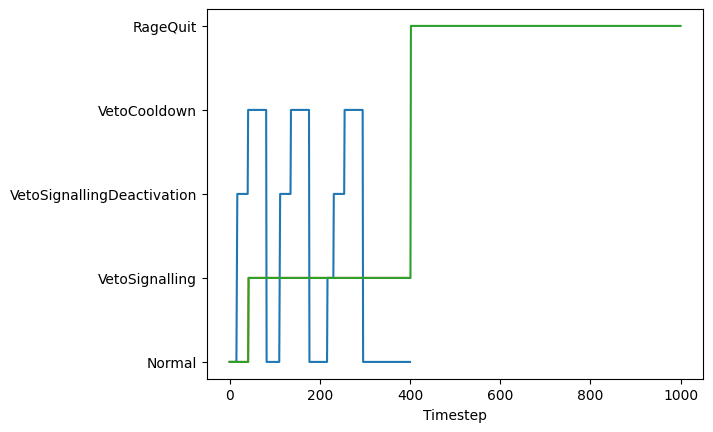

In [76]:
state_dict = {}
for result in results:
    result_seed = result[0]['seed']
    state_dict[result_seed] = []
    for frame in result:
        state_dict[result_seed].append(frame['dual_governance'].state.state)
    plt.plot([v.value for v in state_dict[result_seed]])
    ax = plt.gca()

state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
ax.set_yticks(list(state_names.keys()), labels=list(state_names.values()));
ax.set_xlabel('Timestep')

# Preparing actor data for visualization

In [78]:
actors_df = create_actors_df(results)
actors_df.drop(columns=actors_df.columns[0], inplace=True)
actors_df['total_coins_balance'] = actors_df.wstETH_balance + actors_df.st_eth_balance
actors_df['total_coins_locked'] = actors_df.wstETH_locked + actors_df.st_eth_locked
actors_df['actor_locked'] = actors_df['total_coins_locked'] > 0
actors_df['actor_locked'] = actors_df['total_coins_locked'] > 0
total_actors = len(actors_df.id.unique())

sum_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()
sum_by_actors.drop(columns=['id', 'last_locked_tx_timestamp'], inplace=True)
actors_df = actors_df.merge(sum_by_actors, on=['seed', 'timestep'], suffixes=('', '_sum'))

actors_df['total_coins_balance_relative'] = (actors_df['total_coins_balance'] / actors_df['total_coins_balance_sum']).replace(np.nan, 0)
actors_df['total_coins_locked_relative'] = (actors_df['total_coins_locked'] / actors_df['total_coins_balance_sum']).replace(np.nan, 0)
actors_df['actor_locked_relative'] = actors_df['actor_locked'] / total_actors
actors_df['health_relative'] = actors_df['health'] / actors_df['health_sum'][0]
actors_df['count'] = 1

actors_df_summed_by_actors_rts = actors_df.groupby(by=['seed', 'timestep', 'reaction_time'], sort=False).sum(numeric_only=True).reset_index()
actors_df_summed_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()

reaction_delay 2176221
id 2176221
actor_type 2176221
address 2176221
entity 2176221
ldo_balance 2176221
st_eth_balance 2176221
initial_st_eth_balance 2176221
st_eth_locked 2176221
wstETH_balance 2176221
initial_wstETH_balance 2176221
wstETH_locked 2176221
hypothetical_stETH_balance 2176221
hypothetical_wstETH_balance 2176221
last_locked_tx_timestamp 2176221
starting_health 2176221
health 2176221
total_damage 2176221
total_recovery 2176221
recovery_time 2176221
governance_goal 2176221
reaction_time 2176221
governance_participation 2176221
initial_health 2176221
seed 2176221
timestep 2176221


# Visualizing actor and state data for each simulation run

In [81]:
import matplotlib.ticker as ticker


ys = ('total_coins_locked_relative', 'actor_locked_relative', 'health_relative')
titles = ('Proportion of locked tokens', 'Proportion of locked actors', 'System health')

for i, result_dir in enumerate(result_dirs):
    result_seed = results[i][0]['seed']
    basesize = 5
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * len(ys)), nrows=len(ys) + 1, sharex=True)
    for i, y in enumerate(ys):
        ax1 = axes[i]
        sns.lineplot(actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts['seed'] == result_seed], x='timestep', y=y, hue='reaction_time', ax=ax1, estimator=None, units='seed')
        ax1.set_xlabel('Time (hours)')
        ax1.set_xticks(np.arange(0,1100,100))
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(25))
        # ax1.set_ylim(0, 0.15)
        # ax1.set_xlim(0, 40)
        ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
        ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    
        if i == 0:
            ax2 = ax1.twiny()
            ax2.grid(True)
            ax2.set_xlabel('Timesteps')
            ax2.set_xticks(ax1.get_xticks())
            ax2.set_xlim(ax1.get_xlim())
        if i != len(ys) - 1:
            plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.grid(True)
        ax1.grid(True, which='minor', linestyle='--')
        ax2.grid(True)
        
        title = titles[i]
        ax1.set_title(title)
    
    ax = axes[-1]
    ax.plot([v.value for v in state_dict[result_seed]])
    
    state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
    ax.set_yticks(list(state_names.keys()), labels=list(state_names.values()));
    ax.set_xlabel('Time (hours)')
    ax.grid(True)
    ax.grid(True, which='minor', linestyle='--')
    ax.set_title('DG system state')
    
    fig.savefig(result_dir.joinpath('Lock dynamics' + '.png'))
    plt.close(fig)
# sns.lineplot(actors_df, x='timestep', y='wstETH_locked', hue='reaction_time')